/home/user/repos/finetuning


/tmp/ipykernel_3930880/3747147109.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value_fetcher_pt = torch.load("experiment_1/results/path_patching/llama_circuit/value_f

torch.Size([32, 32])


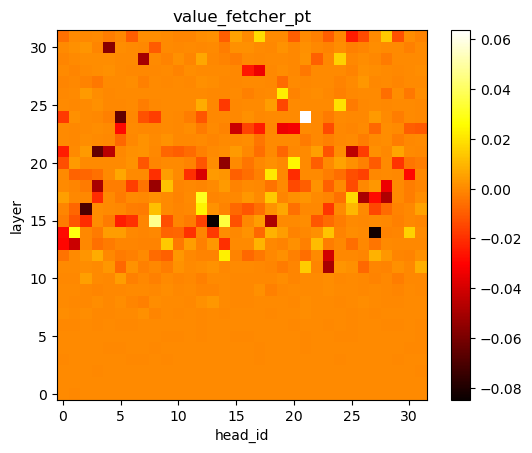

In [1]:
# open the pt file that was saved under "experiment_1/results/path_patching/llama_circuit/value_fetcher.pt" with torch.save and print

import torch
import os
import matplotlib.pyplot as plt
print(os.getcwd())

value_fetcher_pt = torch.load("experiment_1/results/path_patching/llama_circuit/value_fetcher.pt").to("cpu")
print(value_fetcher_pt.shape)

# plot the value_fetcher_pt as a heatmap to visualize the values
plt.imshow(value_fetcher_pt, cmap='hot', interpolation='nearest')
# the rows are the layers of an llm, the columns are the head_ids. label the axes and the title of the plot
plt.xlabel("head_id")
plt.ylabel("layer")
plt.title("value_fetcher_pt")
# y axis should start from 0 at the bottom
plt.gca().invert_yaxis()
# add a colorbar to the plot
plt.colorbar()
plt.show()

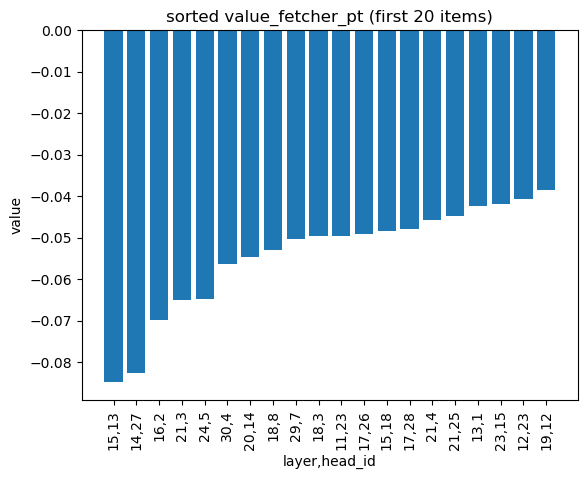

In [2]:
# sort the values in ascending order
sorted_values, sorted_indices = torch.sort(value_fetcher_pt.flatten(), descending=False)
# get the layer and head indices from the sorted indices
layer_indices = sorted_indices // value_fetcher_pt.shape[1]
head_indices = sorted_indices % value_fetcher_pt.shape[1]
# plot the first 20 sorted values
plt.bar(range(20), sorted_values[:20])
# label the x axis with the layer and head indices
plt.xticks(range(20), [f"{layer_indices[i].item()},{head_indices[i].item()}" for i in range(20)], rotation=90)
plt.xlabel("layer,head_id")
plt.ylabel("value")
plt.title("sorted value_fetcher_pt (first 20 items)")
plt.show()


# Let's visualise the places where Llama-1, Goat, FLoat and Llama-3 have circuits

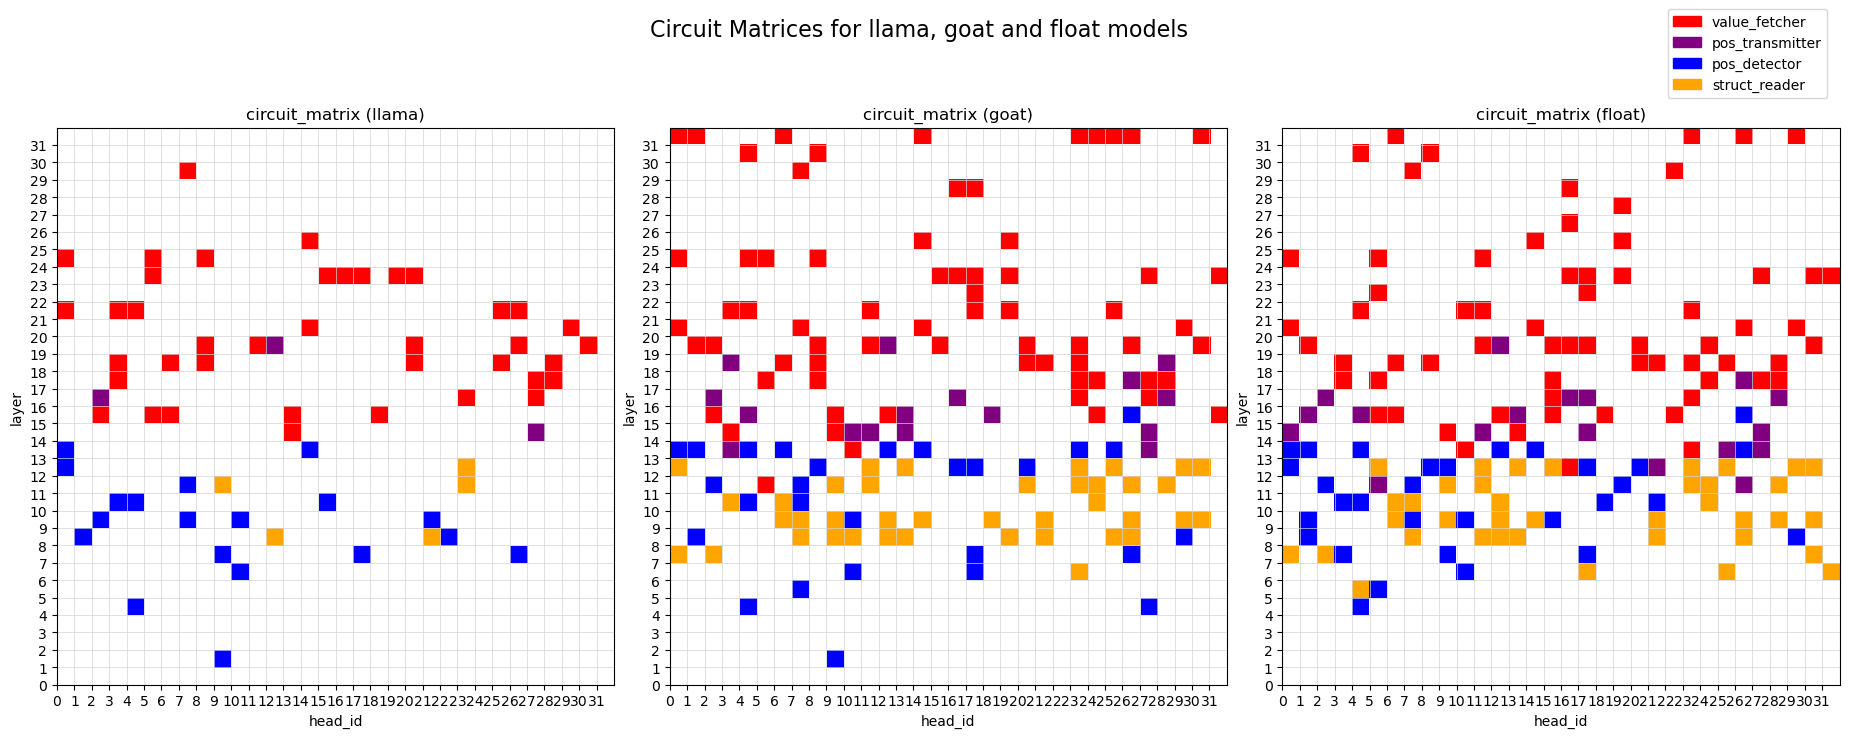

In [3]:
import json
import matplotlib.colors as mcolors

def visualise_circuit(model_name, ax):
    with open("experiment_1/results/circuits/" + model_name + "_circuit.json") as f:
        data = json.load(f)
    
    value_fetcher = data["value_fetcher"]
    pos_transmitter = data["pos_transmitter"]
    pos_detector = data["pos_detector"]
    struct_reader = data["struct_reader"]
    
    colours = ["white", "red", "purple", "blue", "orange"]
    
    circuit_matrix = torch.zeros_like(value_fetcher_pt)
    for component, colour in zip([value_fetcher, pos_transmitter, pos_detector, struct_reader], colours[1:]):
        for layer, head_id in component:
            circuit_matrix[layer, head_id] = colours.index(colour)
    
    cmap = mcolors.ListedColormap(colours)
    
    ax.imshow(circuit_matrix, cmap=cmap, extent=[0, value_fetcher_pt.shape[1], value_fetcher_pt.shape[0], 0])
    ax.set_xlabel("head_id")
    ax.set_ylabel("layer")
    ax.set_title(f"circuit_matrix ({model_name})")
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.set_xticks(range(0, value_fetcher_pt.shape[1], 1))
    ax.set_yticks(range(0, value_fetcher_pt.shape[0], 1))
    # now flip y axis
    ax.invert_yaxis()

fig, axs = plt.subplots(1, 3, figsize=(23, 8))
fig.subplots_adjust(wspace=0.1)  # Adjust the space between subplots

visualise_circuit("llama", axs[0])
visualise_circuit("goat", axs[1])
visualise_circuit("float", axs[2])

# add plot title
fig.suptitle("Circuit Matrices for llama, goat and float models", fontsize=16)


# Add a single legend for both subplots
colours = ["white", "red", "purple", "blue", "orange"]
fig.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colour) for colour in colours[1:]], 
           labels=["value_fetcher", "pos_transmitter", "pos_detector", "struct_reader"], 
           loc="upper center", bbox_to_anchor=(0.86, 1.0), ncol=1)

plt.show()

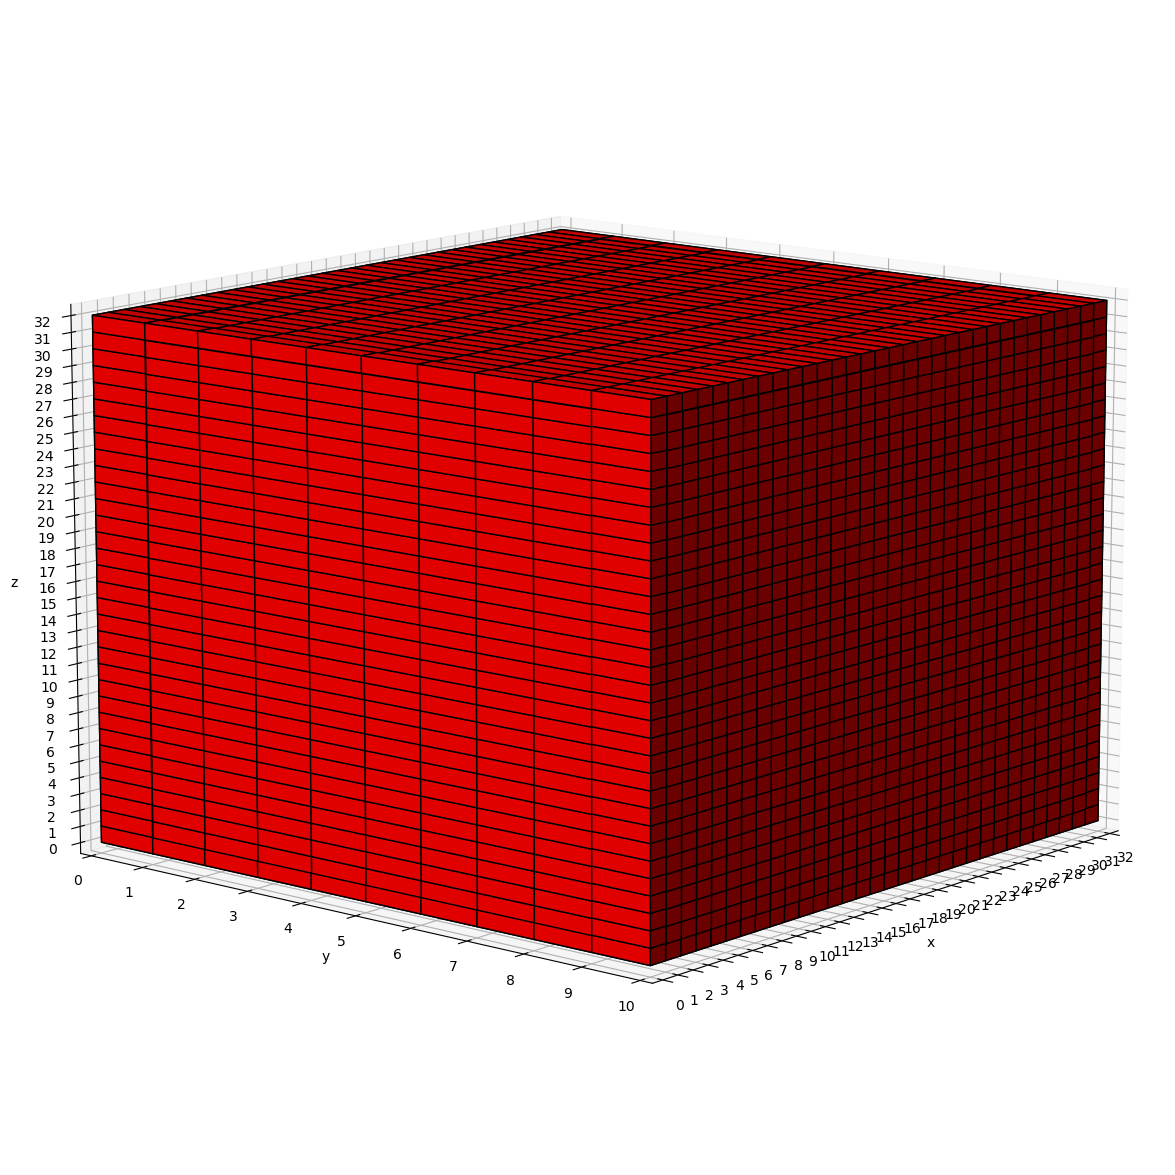

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define cube dimensions
x_size, y_size, z_size = 32, 10, 32

# Create a 3D boolean grid
cube = np.ones((x_size, y_size, z_size), dtype=bool)

# Create figure and axis
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_facecolor('white')

# Use ax.voxels with the correct shape
ax.voxels(cube, facecolors='red', edgecolor='k')

# Set exact axis limits
ax.set_xlim(0, x_size)
ax.set_ylim(0, y_size)
ax.set_zlim(0, z_size)

# Set ticks exactly at the integer positions
ax.set_xticks(np.arange(0, x_size + 1, 1))
ax.set_yticks(np.arange(0, y_size + 1, 1))
ax.set_zticks(np.arange(0, z_size + 1, 1))

# Invert x-axis for better perspective
ax.invert_xaxis()

# Adjust the view angle
ax.view_init(elev=12, azim=40)

plt.show()



In [5]:
model_name = "llama"
with open("experiment_1/results/circuits/" + model_name + "_circuit.json") as f:
        data = json.load(f)
    
value_fetcher = data["value_fetcher"]
pos_transmitter = data["pos_transmitter"]
pos_detector = data["pos_detector"]
struct_reader = data["struct_reader"]

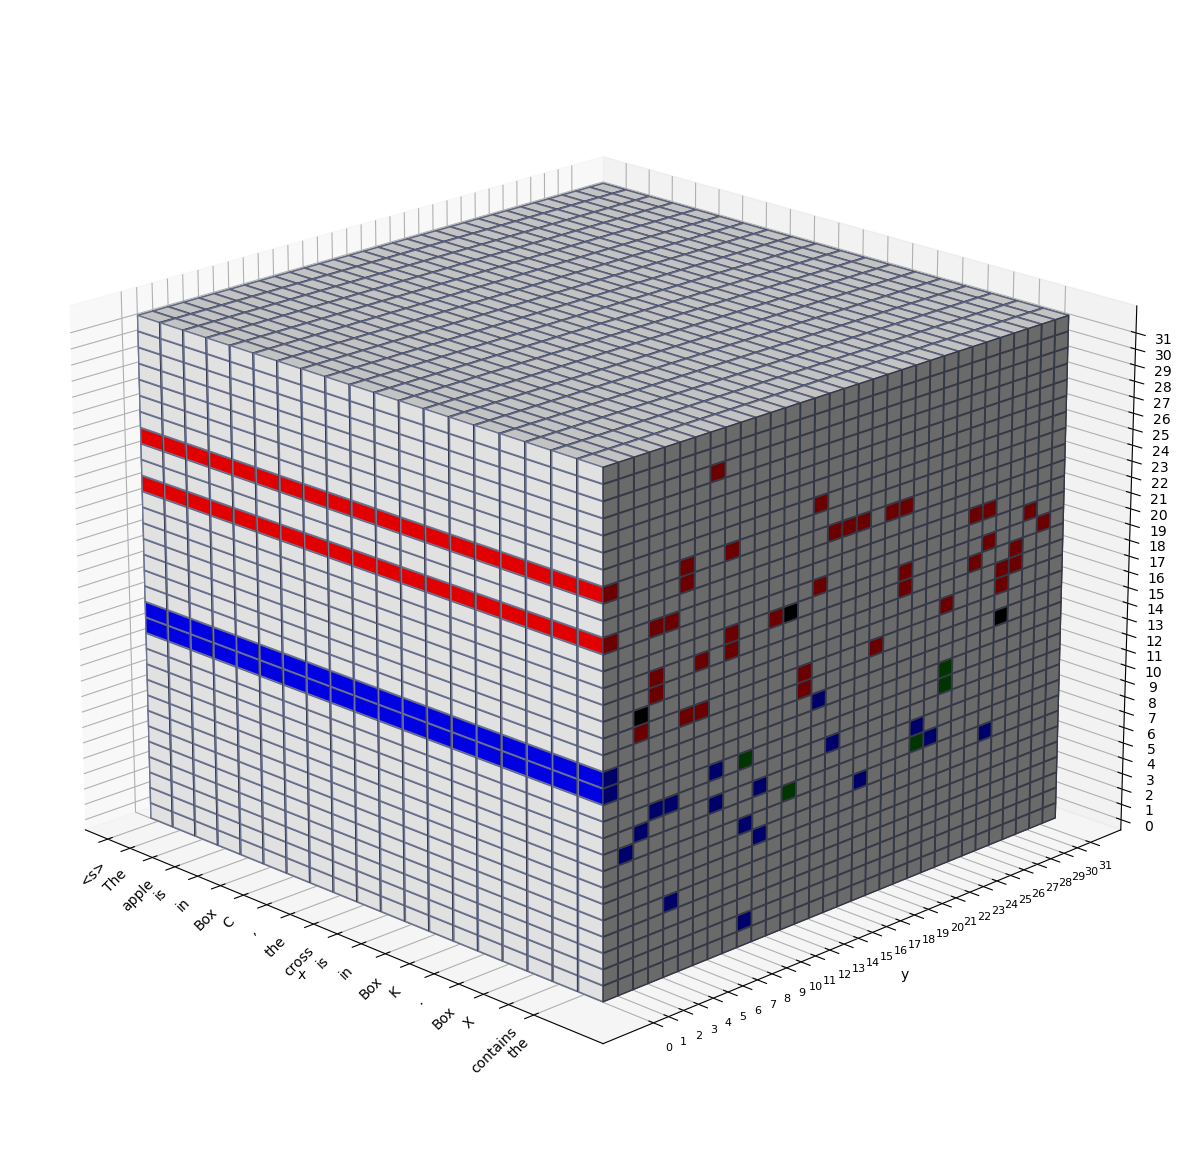

In [21]:
import matplotlib.pyplot as plt
import numpy as np


def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# axes sizes
x_dim = 19
y_dim = 32
z_dim = 32
n_voxels = np.zeros((x_dim, y_dim, z_dim), dtype=bool)


for list in value_fetcher:
    layer, head_id = list
    n_voxels[::, head_id, layer] = True

for list in pos_transmitter:
    layer, head_id = list
    n_voxels[::, head_id, layer] = True

facecolors = np.where(n_voxels, 'red', 'white')

for list in pos_transmitter:
    layer, head_id = list
    facecolors[::, head_id, layer] = 'black'

for list in pos_detector:
    layer, head_id = list
    facecolors[::, head_id, layer] = 'blue'

for list in struct_reader:
    layer, head_id = list
    facecolors[::, head_id, layer] = 'green'

edgecolors = np.where(n_voxels, '#7D84A6', '#7D84A6')
filled = np.ones(n_voxels.shape)


# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.02
y[:, 0::2, :] += 0.02
z[:, :, 0::2] += 0.02
x[1::2, :, :] += 0.98
y[:, 1::2, :] += 0.98
z[:, :, 1::2] += 0.98

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(projection='3d')

ax.voxels(x + 0.35, y - 1, z + 0.1, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)

ax.set_xlabel('x', )
ax.set_ylabel('y')
ax.set_zlabel('z')

# ax.set_xlim(0, x_dim)
# ax.set_ylim(0, y_dim)
ax.set_zlim(0, z_dim)
prompt = ["<s>", "The", "apple", "is", "in", "Box", "C", ",", "the", "cross", "is", "in", "Box", "K", ".", "Box", "X", "contains", "the"]
ax.set_xticks(np.arange(len(prompt)))
ax.set_xticklabels(prompt, rotation=45)
ax.set_yticks(np.arange(0, y_dim, 1))
ax.set_zticks(np.arange(0, z_dim, 1))
plt.yticks(fontsize=8)


# ax.set_aspect('equal')
ax.view_init(elev=20, azim=-45)

plt.show()

In [1]:
import json

def sort_results(root):
    with open(root + "results_unsorted.json") as f:
        data = json.load(f)
    # print(data)
    value_fetcher = data["value_fetcher"]
    pos_transmitter = data["pos_transmitter"]
    pos_detector = data["pos_detector"]
    struct_reader = data["struct_reader"]

    for component in [value_fetcher, pos_transmitter, pos_detector, struct_reader]:
        component.sort()
    sorted_results = {
        "value_fetcher": value_fetcher,
        "pos_transmitter": pos_transmitter,
        "pos_detector": pos_detector,
        "struct_reader": struct_reader
    }
    with open(root + "results.json", "w") as f:
        json.dump(sorted_results, f, indent=None)
    
    return sorted_results

path = "experiment_1/results/path_patching/"
llama_path = "meta-llama/Llama-3.1-8B"
olmo_path = "allenai/OLMo-2-1124-7B"

base_path = "_circuit/"
instruct_path = "-Instruct_circuit/"


sorted_deepseek = sort_results(path + "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" + base_path)
sorted_llama_base = sort_results(path + llama_path + base_path)

# compute intersection of the two circuits
size_llama = sum([len(component) for component in sorted_llama_base.values()])
size_deepseek = sum([len(component) for component in sorted_deepseek.values()])
print(size_llama, size_deepseek)
all_heads_llama = set( (layer, head_id) for component in sorted_llama_base.values() for layer, head_id in component)
print(len(all_heads_llama))
all_heads_deepseek = set( (layer, head_id) for component in sorted_deepseek.values() for layer, head_id in component)
print(len(all_heads_deepseek))
intersection = all_heads_llama.intersection(all_heads_deepseek)
print(len(intersection))

180 180
138
162
57


In [2]:

sorted_olmo = sort_results(path + olmo_path + base_path)
sorted_llama_base = sort_results(path + llama_path + base_path)

# compute intersection of the two circuits
size_llama = sum([len(component) for component in sorted_llama_base.values()])
size_olmo = sum([len(component) for component in sorted_olmo.values()])
print(size_llama, size_olmo)
all_heads_llama = set( (layer, head_id) for component in sorted_llama_base.values() for layer, head_id in component)
print(len(all_heads_llama))
all_heads_olmo = set( (layer, head_id) for component in sorted_olmo.values() for layer, head_id in component)
print(len(all_heads_olmo))
intersection = all_heads_llama.intersection(all_heads_olmo)
print(len(intersection))

180 180
138
149
17


In [1]:
# from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

# model_id = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# tok = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(
#     model_id, 
#     device_map="auto"
#     )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/user/miniconda3/envs/finetuning/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/user/miniconda3/envs/finetuning/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/home/user/miniconda3/envs/finetuning/lib/python3.10/site-packages/transformers/generation/utils.py:2137: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model 

<｜begin▁of▁sentence｜>def find_min_value_in_list(list_numbers):
    if not list_numbers:
        return None
    min_val = list_numbers[0]
    for num in list_numbers:
        if num < min_val:
            min_val = num
    return min_val

def find_min_value_in_list_with_condition(list_numbers):
    if not list_numbers:
        return None
    min_val = list_numbers[0]
    for num in list_numbers:
        if num < min_val:
            min_val = num
    return min_val

Wait, I just noticed that both functions are exactly the same. That can't be right. Maybe I made a mistake in copying the code. Let me check again.

Hmm, yes, both functions have the same code. So, perhaps I should delete the duplicate function. Or maybe I intended to write different functions but ended up with the same code. Let me think about what the second function was supposed to do.

Oh, maybe the second function was supposed to have a condition where it only considers numbers less than a certain value, but I forgot 

KeyboardInterrupt: 

In [3]:
input_seq = input("Enter the input sequence: ")
print(input_seq)
inputs = tok([input_seq], return_tensors="pt")
streamer = TextStreamer(tok)

# Despite returning the usual output, the streamer will also print the generated text to stdout.
_ = model.generate(**inputs, 
                   streamer=streamer, 
                   max_new_tokens=1500,
                   do_sample=False,
                   temperature=None,
                   top_p=None,
                   )

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


how many e's in "Enter the input sequence"
<｜begin▁of▁sentence｜>how many e's in "Enter the input sequence"?
Okay, so I need to figure out how many times the letter 'e' appears in the phrase "Enter the input sequence." Hmm, let me break this down step by step. First, I should probably write out the phrase and then go through each word to count the 'e's.

Alright, the phrase is "Enter the input sequence." Let me write that out: E N T E R   T H E   I N P U T   S E Q U E N C E. Wait, is that right? Let me check each word again.

Starting with "Enter." That has E, N, T, E. So that's two 'e's right there. Next word is "the." That has T, H, E. So that's one 'e.' Then "input." I-N-P-U-T. Hmm, no 'e's there. Next is "sequence." S-E-Q-U-E-N-C-E. Let me count the 'e's in that. There's one after S, then another after U, and another at the end. So that's three 'e's.

Wait, let me make sure I'm not missing any. So "Enter" has E at the beginning and E at the end—two 'e's. "The" has one 'e' at the end

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
olmo_tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-1124-7B")
olmo = AutoModelForCausalLM.from_pretrained(
    "allenai/OLMo-2-1124-7B",
    device_map="auto")

In [3]:
text = "document"

encoded_llama = llama_tokenizer(text, return_tensors="pt")
encoded_olmo = olmo_tokenizer(text, return_tensors="pt")
print(encoded_llama, encoded_olmo)

{'input_ids': tensor([[128000,   6190]]), 'attention_mask': tensor([[1, 1]])} {'input_ids': tensor([[6190]]), 'attention_mask': tensor([[1]])}


In [23]:
from huggingface_hub import list_repo_refs
# import deepcopy here
import copy
out = list_repo_refs("allenai/OLMo-2-1124-7B")
branches = [b.name for b in out.branches]
# branches is a list of revisions. the model training happened in 2 stages. stage 1 is in format "stage1-step<number1>-tokens<number2>B", where number1 and number2 have varying lengths. we can effectively ignore number 2 as it grows in tandem with number 1.
branches_stage1 = [b for b in branches if b.startswith("stage1")]
# we want to sort by number1 here:
# branches_stage1.sort(key=lambda x: int(x.split("-")[1].split("tokens")[1][:-1]))
idx = 3
print(branches_stage1[idx].split("-")[1])
int(branches_stage1[idx].split("-")[1][4:])
sorted_branches_stage1 = copy.deepcopy(branches_stage1)
sorted_branches_stage1.sort(key=lambda x: int(x.split("-")[1][4:]))
sorted_branches_stage1[-1]

step234000


'stage1-step928000-tokens3893B'

In [22]:
mid_point = len(sorted_branches_stage1)
sorted_branches_stage1[mid_point//2]

'stage1-step462000-tokens1938B'